Подготовить данные для модели:
    
   Анализ данных, необходимые корректировки. 
1. Обработать пропуски. 
2. Оценить выбросы. 
3. Корреляция. 
4. Тест на нормальность распределения.
5. Масштабировать данные.


Задача: есть данные, что тест на болезнь дает результат с вероятностью в 98%. Число больных в популяции у нас 1%. 
Вопрос - с какой вероятностью положительный тест будет положительным при случайном тестировании.  

Вероятность что человек болен - Р(А) = 0.01
Вероятность положительного теста если человек болен - Р(В|A) = 0.98
Вероятность ложноположительного теста если человек здоров - Р(В|!A) = 0.02

Вероятность положительного теста
Р(В) = Р(В|A)*Р(А)+Р(В|!A)*Р(!А) = (0,98*0,01)+(0,99*0,02) = 0.0296

По формуле Байеса
P(A|B) = Р(В|A)*Р(А)/Р(B) = 0.98*0.01/0.0296 = 0.33

Вероятность что человек болен при положительном тесте 33%.

In [214]:
import pandas as pd
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

Загружаем данные из csv файла.

In [215]:
df = pd.read_csv('credit_train.csv',on_bad_lines='skip', encoding='windows-1251', delimiter=';')

In [216]:
df.describe()

,client_id,age,credit_month,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,170746.000000,170743.000000,170746.000000,170741.000000,161516.000000,161516.000000,170746.000000
mean,85373.500000,36.497262,10.980749,40138.596149,2.107308,0.046070,0.176028
std,49290.268869,10.546044,3.536698,25044.373992,1.777128,0.211548,0.380845
min,1.000000,18.000000,3.000000,5000.000000,0.000000,0.000000,0.000000
25%,42687.250000,28.000000,10.000000,25000.000000,1.000000,0.000000,0.000000
50%,85373.500000,34.000000,10.000000,35000.000000,2.000000,0.000000,0.000000
75%,128059.750000,43.000000,12.000000,50000.000000,3.000000,0.000000,0.000000
max,170746.000000,71.000000,36.000000,950000.000000,21.000000,3.000000,1.000000


In [217]:
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,59998,10,1.6.24,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889,6,1.1.24,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728,12,1.1.24,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1.24,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1.24,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,64867,12,1.1.24,"0,535257",GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24.0,MAR,SPC,17640,6,1.6.24,"0,573287",SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,"27556,47",10,1.1.32,"0,416098",GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,6189,12,1.1.24,"0,482595",SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


Необходимо подготовить данные.
1. Исключим из столбца living_region небуквенные значения, а также слова, не несущие смысловой нагрузки и мешающие дальнейшему анализу.

In [218]:
df['living_region'] = df['living_region'].str.replace(r'[^а-яА-Яa-zA-Z\s]', '', regex=True)

trash_words = ['РЕСП','РЕСП.','РЕСПУБЛИКА', 'САХА', 'ОБЛ','АОБЛ', 'АВТОНОМНЫЙ ОКРУГ','ЮГРА', 'ЧУВАШИЯ', 'ФЕДЕРАЛЬНЫЙ ОКРУГ', 'АО', 'ОБЛАСТЬ', 'КРАЙ', 'Г', 'Ю', 'СЕВ.', 'СЕВЕРНАЯ', 'АЛАНИЯ', ' ']

pattern = r'\b(?:' + '|'.join(map(re.escape, trash_words)) + r')\b'

df = df.applymap(lambda x: re.sub(pattern, '', x) if isinstance(x, str) else x)

C:\Users\LP\AppData\Local\Temp\ipykernel_6500\1492641804.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(pattern, '', x) if isinstance(x, str) else x)


Также удаляем строки с неорректными значениями '1.0' в поле tariff_id.

In [219]:
df = df[df['tariff_id'] != '1.0']

2. Оценим количество пропусков в данных.

In [220]:
print(df.isna().sum())  # Количество пропусков в каждом столбце
print(df.isna().mean()*100) # Процент пропусков в каждом столбце


client_id                  0
gender                     0
age                        3
marital_status             3
job_position               0
credit_sum                 2
credit_month               0
tariff_id                  0
score_shk                  7
education                  5
living_region            192
monthly_income             5
credit_count            9167
overdue_credit_count    9167
open_account_flg           0
dtype: int64
client_id               0.000000
gender                  0.000000
age                     0.001780
marital_status          0.001780
job_position            0.000000
credit_sum              0.001187
credit_month            0.000000
tariff_id               0.000000
score_shk               0.004154
education               0.002967
living_region           0.113946
monthly_income          0.002967
credit_count            5.440324
overdue_credit_count    5.440324
open_account_flg        0.000000
dtype: float64


Наибольшее количество пропусков  - в столбцах credit_count и overdue_credit_count. Заменим их на медианные значения столбцов. Остальные строки с пропусками удалим, так как процент данных с пропусками небольшой.

In [221]:
df['credit_count'] = df['credit_count'].fillna(df['credit_count'].median())
df['overdue_credit_count'] = df['overdue_credit_count'].fillna(df['overdue_credit_count'].median())
df = df.dropna()

In [222]:
df.describe()

,client_id,age,credit_month,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,168298.000000,168298.000000,168298.000000,168298.000000,168298.000000,168298.000000,168298.000000
mean,85397.665100,36.486880,10.927569,40171.177738,2.100887,0.043577,0.177643
std,49287.259671,10.542829,3.449106,25067.884952,1.729175,0.206008,0.382213
min,8.000000,18.000000,3.000000,5000.000000,0.000000,0.000000,0.000000
25%,42701.250000,28.000000,10.000000,25000.000000,1.000000,0.000000,0.000000
50%,85406.500000,34.000000,10.000000,35000.000000,2.000000,0.000000,0.000000
75%,128080.750000,43.000000,12.000000,50000.000000,3.000000,0.000000,0.000000
max,170746.000000,71.000000,36.000000,950000.000000,21.000000,3.000000,1.000000


In [223]:
df.dtypes

client_id                 int64
gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum               object
credit_month              int64
tariff_id                object
score_shk                object
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
open_account_flg          int64
dtype: object

Выполниим преобразование типов

In [224]:
df['tariff_id'] = pd.to_datetime(df['tariff_id'], dayfirst=True) # Приводим tariff_id к формату даты

C:\Users\LP\AppData\Local\Temp\ipykernel_6500\2037385917.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tariff_id'] = pd.to_datetime(df['tariff_id'], dayfirst=True) # Приводим tariff_id к формату даты


Преобразуем столбцы credit_sum, score_shk к типу float для дальнейшего анализа.

In [225]:
df['credit_sum'] = df['credit_sum'].str.replace(',', '.', regex=False)
df['credit_sum'] = df['credit_sum'].astype(float)

In [226]:
df['score_shk'] = df['score_shk'].str.replace(',', '.', regex=False)
df['score_shk'] = df['score_shk'].astype(float)

open_account_flg приводим к типу bool, так как это флаг.

In [227]:
df['open_account_flg'] = df['open_account_flg'].astype(bool)

Оценим количество значений living_region

In [228]:
data=df['living_region'].value_counts()
data = data.to_frame()
data

,count
living_region,
МОСКОВСКАЯ,12755
МОСКВА,9146
КРАСНОДАРСКИЙ,8306
САНКТПЕТЕРБУРГ,8049
ТАТАРСТАН,7665
...,...
ПРИВОЛЖСКИЙ,1
КРАЙПЕРМСКИЙ,1
МЫТИЩИНСКИЙРН,1


Построим график частоты встречаемости различных регионов

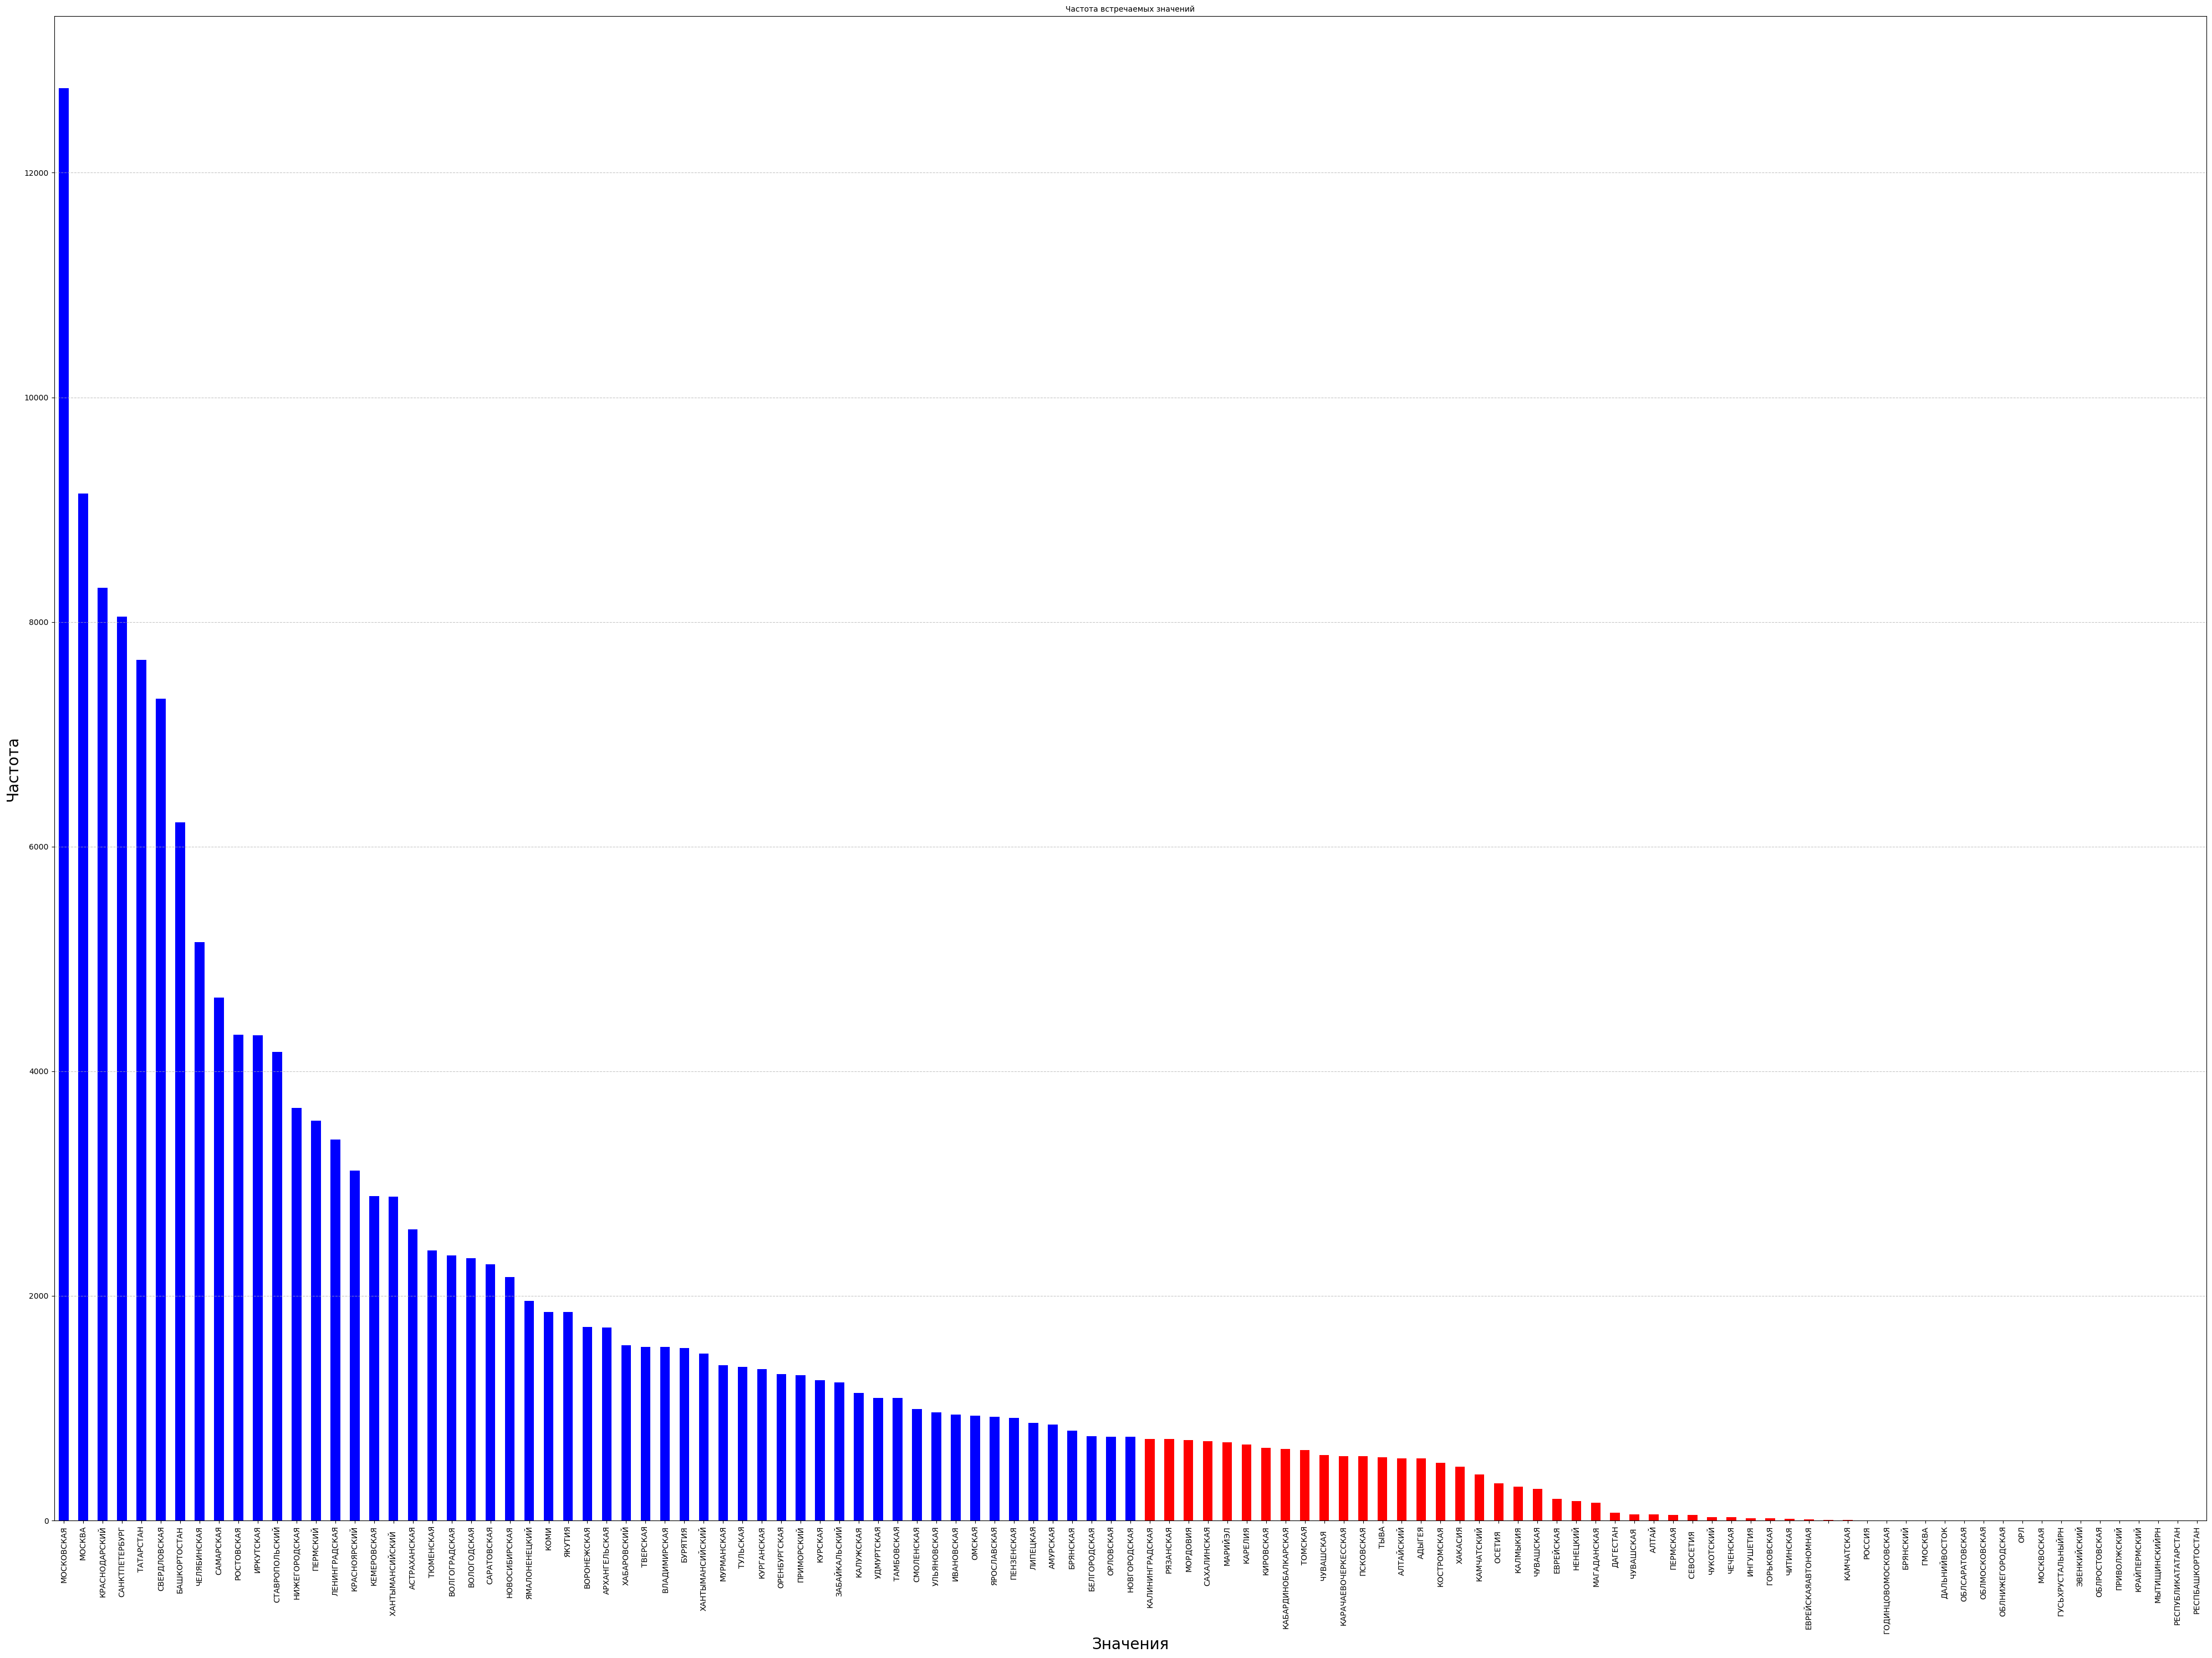

In [229]:
import pandas as pd
import matplotlib.pyplot as plt

value_counts = df['living_region'].value_counts()

color = ['red' if value < value_counts.median() else 'blue' for value in value_counts]
value_counts.plot(kind='bar', color=color, figsize=(40, 30))

# Настройка графика
plt.title('Частота встречаемых значений', fontsize=10)
plt.xlabel('Значения', fontsize=20)
plt.ylabel('Частота', fontsize=20)
plt.xticks(rotation=90)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
# Отображение графика
plt.show()

In [274]:
print("Медианное значение", value_counts.median())

Медианное значение 744.0


Регионы, количество которых в выборке меньше 744, сгруппируем в Другие.

In [231]:

# Установим минимальный порог для частоты категории
threshold = value_counts.median()  # Группируем категории, количество которых в выборке ниже медианного значения
city_counts = df['living_region'].value_counts()

# Заменяем редкие города на "Другие"
df['living_region'] = df['living_region'].apply(lambda x: x if city_counts[x] > threshold else 'Другие')


In [232]:
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
7,8,F,26.0,UNM,SPC,47878.00,10,2024-01-01,0.512525,GRD,МОСКОВСКАЯ,60000.0,3.0,0.0,False
9,10,F,32.0,UNM,SPC,26268.00,10,2024-01-01,0.465026,GRD,СТАВРОПОЛЬСКИЙ,39500.0,7.0,0.0,False
12,13,M,37.0,MAR,SPC,42289.00,10,2024-06-01,0.691609,SCH,АРХАНГЕЛЬСКАЯ,70000.0,1.0,0.0,False
13,14,M,43.0,MAR,INP,57567.00,10,2024-01-01,0.341164,GRD,ХАНТЫМАНСИЙСКИЙ,60000.0,7.0,0.0,False
15,16,M,34.0,MAR,SPC,13209.00,10,2024-01-01,0.498255,SCH,ПЕРМСКИЙ,34000.0,2.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,64867.00,12,2024-01-01,0.535257,GRD,ТАТАРСТАН,40000.0,6.0,0.0,False
170742,170743,F,24.0,MAR,SPC,17640.00,6,2024-06-01,0.573287,SCH,САНКТПЕТЕРБУРГ,30000.0,1.0,0.0,False
170743,170744,F,31.0,UNM,SPC,27556.47,10,2032-01-01,0.416098,GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,False
170744,170745,F,53.0,DIV,PNA,6189.00,12,2024-01-01,0.482595,SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,False


Выполним преобразование категориальных столбцов с помощью OneHotEncoder

In [233]:

categorical_features = ['gender', 'marital_status', 'job_position', 'education','living_region']
numerical_features = ['client_id', 'age', 'credit_sum', 'credit_month','tariff_id', 'score_shk', 'monthly_income','credit_count','overdue_credit_count','open_account_flg']
categorical_transformer = OneHotEncoder(sparse_output = False)
original_dtypes = df.dtypes.to_dict()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

transformed_data = preprocessor.fit_transform(df)
#dense_data = transformed_data.toarray()

#print(transformed_data)


In [234]:
transformed_data.shape

(168298, 96)

И объединим столбцы обратно в DataFrame, назначив категориальным столбцам тип category.

In [235]:
categorical_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = list(categorical_columns) + numerical_features
transformed_df = pd.DataFrame(transformed_data, columns=all_columns)
for col in all_columns:
    if col in original_dtypes:
        transformed_df[col] = transformed_df[col].astype(original_dtypes[col])
    else:
         transformed_df[col]= transformed_df[col].astype('category')
#print(transformed_df)

In [236]:
print(transformed_df.dtypes)

gender_F                category
gender_M                category
marital_status_CIV      category
marital_status_DIV      category
marital_status_MAR      category
                          ...   
score_shk                float64
monthly_income           float64
credit_count             float64
overdue_credit_count     float64
open_account_flg            bool
Length: 96, dtype: object


Оценим выбросы в данных, построив "ящики с усами" и гистограммы данных.

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns

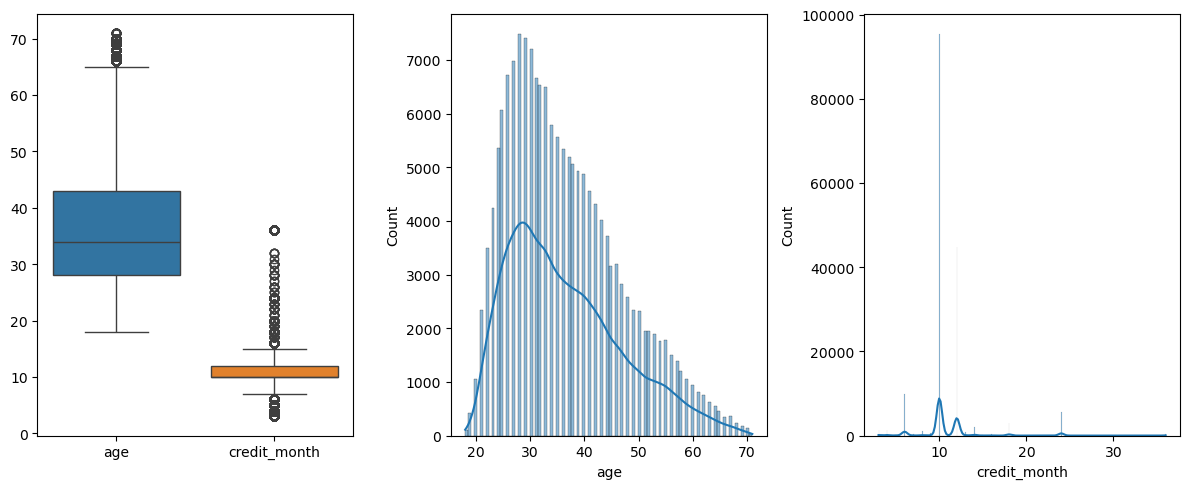

In [238]:
selected_columns = ["age", "credit_month"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 строка, 2 столбца
sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['age'],kde=1,  ax = axes[1])
sns_plot1 = sns.histplot(transformed_df['credit_month'],kde=1,  ax = axes[2])
plt.tight_layout()
plt.show()

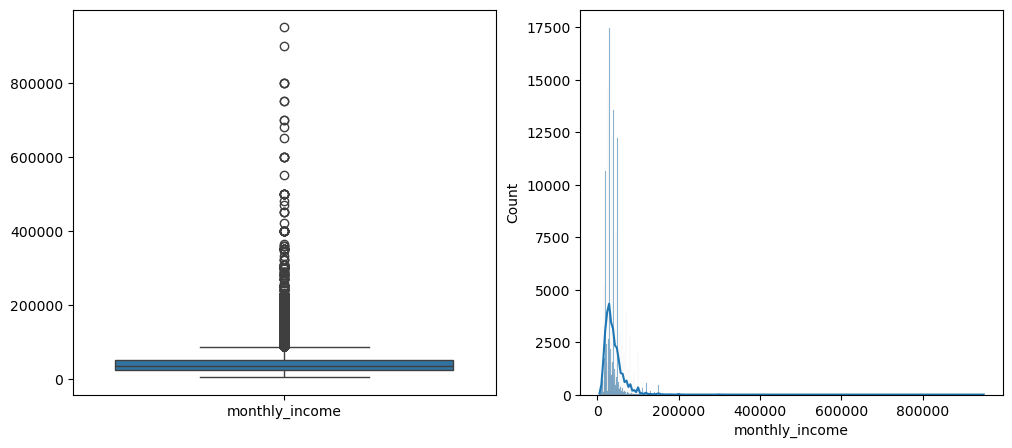

In [239]:
selected_columns = ["monthly_income"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца
box = sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['monthly_income'],kde=1,  ax = axes[1])


plt.show()

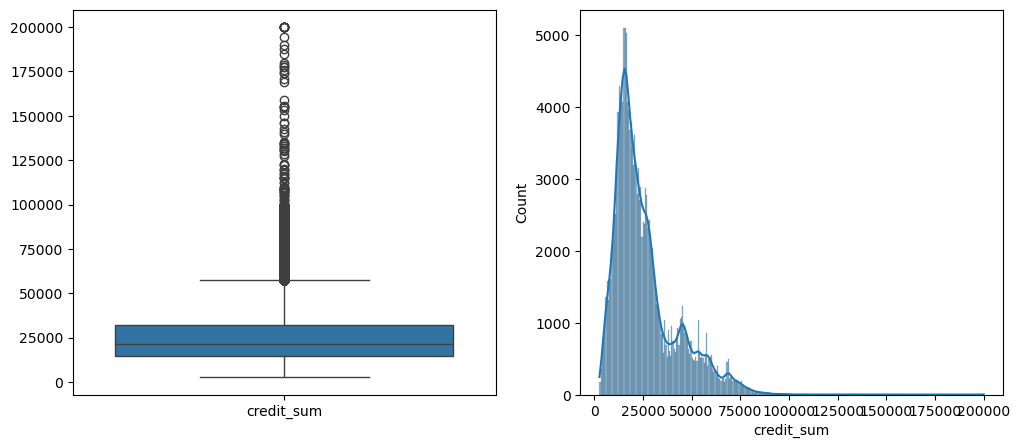

In [240]:
selected_columns = ["credit_sum"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца
box = sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['credit_sum'],kde=1,  ax = axes[1])
plt.show()

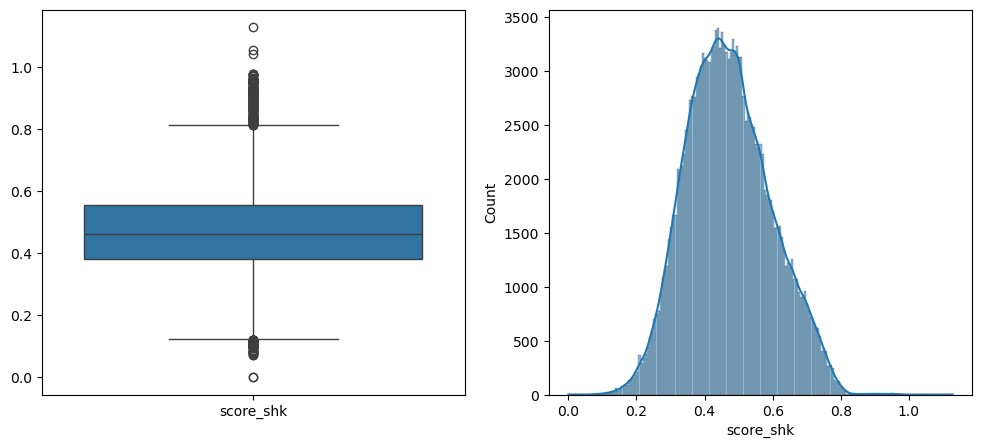

In [241]:

selected_columns = ["score_shk"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца
box = sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['score_shk'],kde=1,  ax = axes[1])
plt.show()

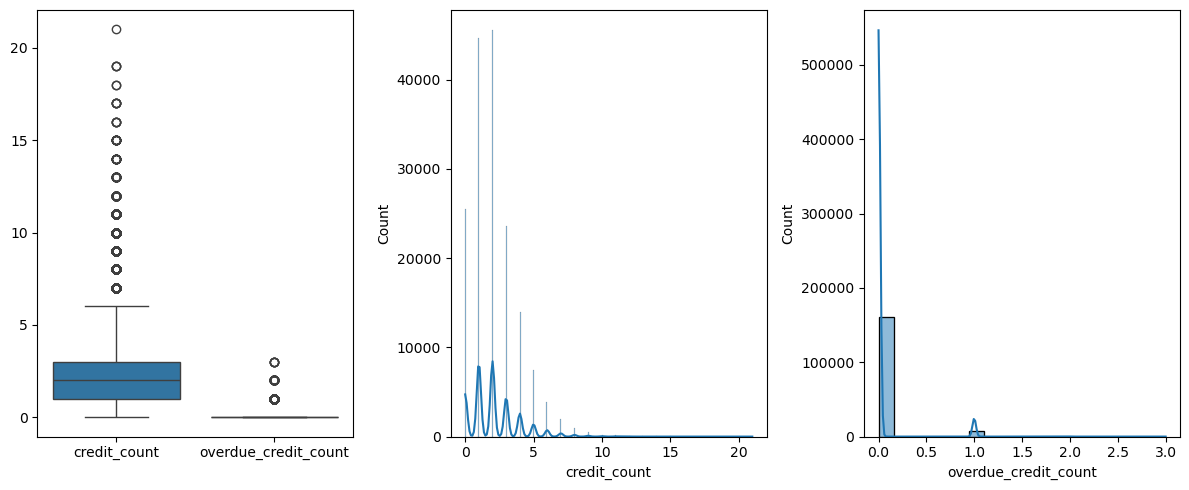

In [242]:
selected_columns = ["credit_count", "overdue_credit_count"]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 строка, 2 столбца
sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['credit_count'],kde=1,  ax = axes[1])
sns_plot1 = sns.histplot(transformed_df['overdue_credit_count'],kde=1,  ax = axes[2])
plt.tight_layout()
plt.show()

Для данных "age", "credit_month", "monthly_income", "credit_sum", "credit_count", "overdue_credit_count","score_shk"  имеет смысл удалить выбросы.
Удалим значения, которые лежат за 1 и 3 квартилями (25 и 75 %).

In [243]:

def remove_outliers(df,columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
columns = ['age', 'credit_month', 'monthly_income', 'credit_sum', 'credit_count', 'score_shk', 'overdue_credit_count']
fitered_transformed_df = remove_outliers(transformed_df, columns)
#print(df)


Построим карту корреляции.

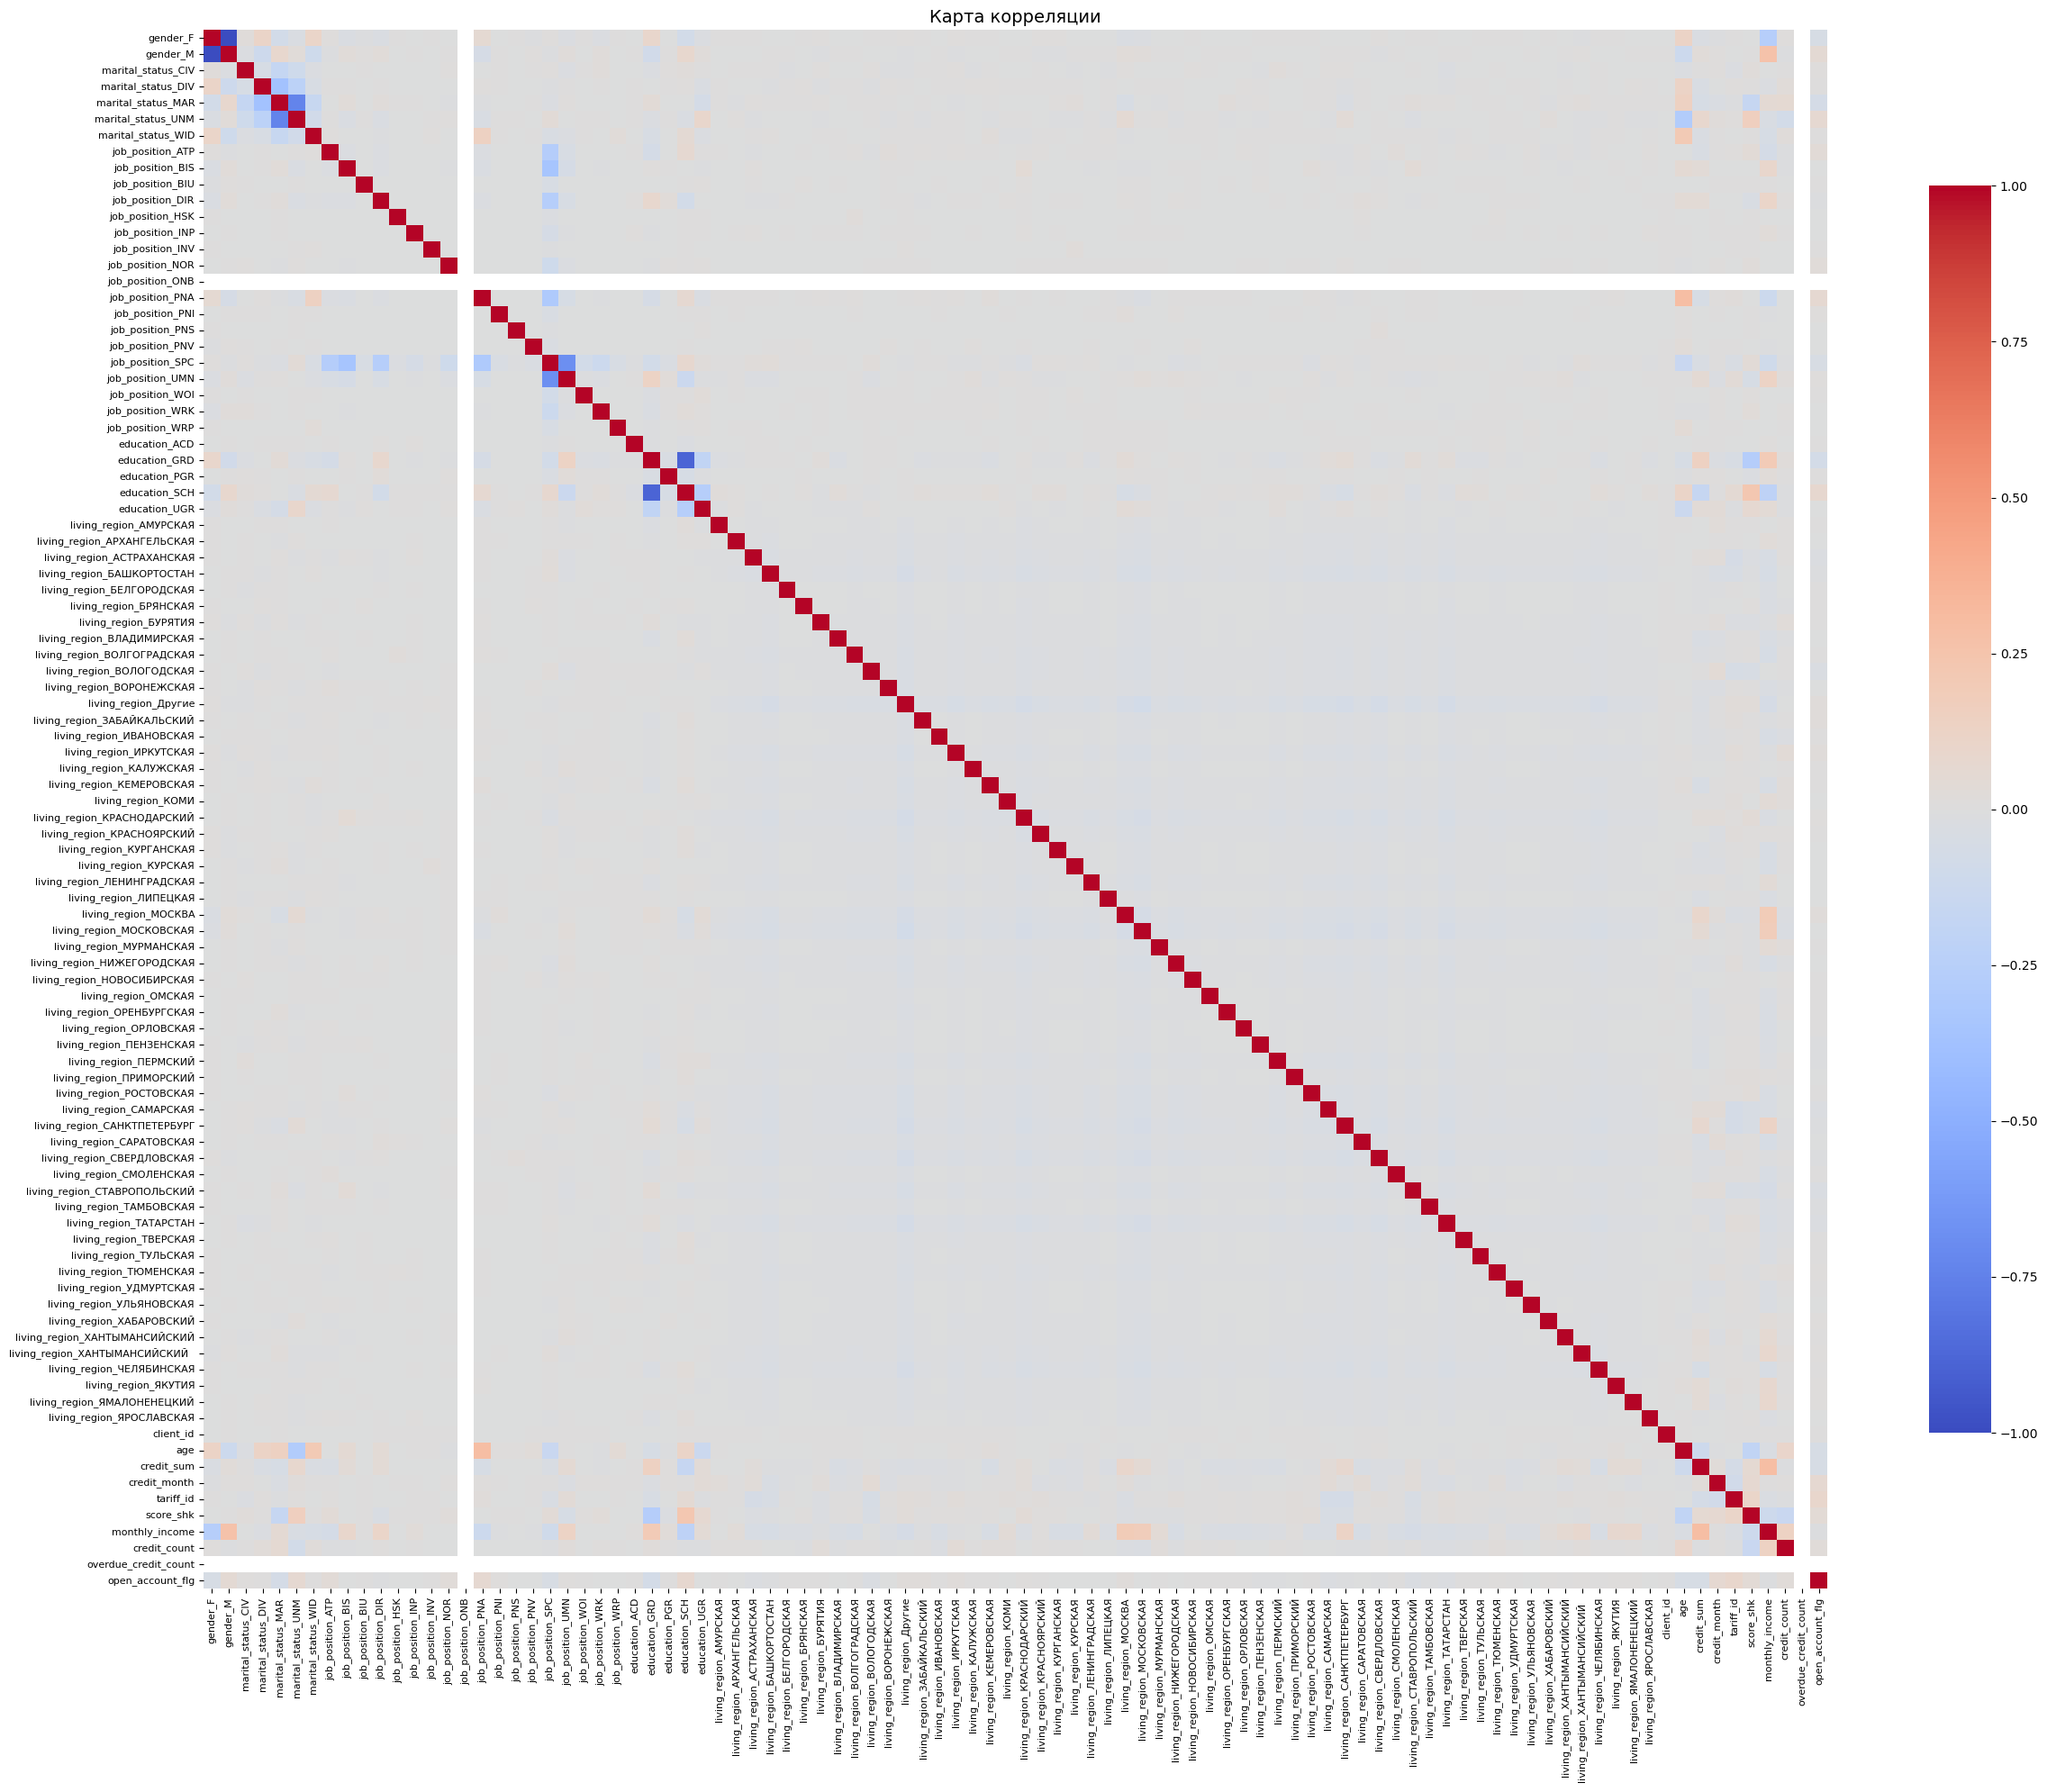

In [270]:
correlation_matrix = fitered_transformed_df.corr()

# Настраиваем размеры фигуры для лучшей читаемости
plt.figure(figsize=(25, 20))  # Размеры графика

sns.heatmap(
    correlation_matrix,
    annot=False,               # Не отображать числовые значения на ячейках
    cmap="coolwarm",           # Цветовая карта
    vmin=-1, vmax=1,           # Ограничения для значений корреляции
    cbar_kws={"shrink": 0.8}   # Уменьшение размера цветовой полосы
)


# Настраиваем подписи осей
plt.xticks(rotation=90, fontsize=8) 
plt.yticks(fontsize=8)               
plt.title("Карта корреляции", fontsize=14)  # Заголовок

plt.tight_layout()  # Подгонка элементов графика
plt.show()

Судя по карте корреляции, прямую корреляцию имеют параметры 'age' и 'job_position_PNA'.

Unmarried (не женат/ не замужем) имеет обратную корреляцию с возрастом (age).
WID (вдова/вдовец) имеет прямую корреляцию с возрастом (age).
Месячный доход (monthly_income) имеет прямую корреляцию с суммой по кредиту, а также с местом проживания (Москва, Московская область), и полом (мужской).

Корреляции, симметричные к диагонали, не имеют смысла, так как представлют взаимоисключающие понятия.
Столбцы overdue_credit_count и job_position_ONB не содержат полезных данных, их можно удалить.

In [275]:

del fitered_transformed_df['overdue_credit_count']
del fitered_transformed_df['job_position_ONB']


Проверим столбцы на нормальное распределение с помощью критерия Пирсона

In [276]:
from scipy.stats import normaltest
normal_counter = {}
for features in fitered_transformed_df.columns:
    if fitered_transformed_df[features].dtype in ['datetime64[ns]', 'bool']: # Исключим булевые типы и даты
        continue
    stat, p = normaltest(fitered_transformed_df[features])
    #print(f"Statistic: {stat}, p-value: {p}")
    if p > 0.05:
        normal_counter[features] = p
if normal_counter:
    for i in normal_counter:
        print (f"Значение {i[0]} распределено нормально, p = {i[1]}")
else:
    print ("В датасете нет нормально распределенных значений")
           


В датасете нет нормально распределенных значений


Выполним скалирование данных используя MinMaxScaler

In [278]:
numerical_scale_features = fitered_transformed_df[['age', 'credit_month', 'monthly_income', 'credit_sum', 'credit_count', 'score_shk']]


In [279]:
from sklearn.preprocessing import MinMaxScaler

#numerical_scale_features = fitered_transformed_df
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_scale_features)

# Преобразование обратно в DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=numerical_scale_features.columns).reset_index(drop=1)

categorical_columns = [col for col in fitered_transformed_df.columns if col not in scaled_data.columns]
categorical_df = fitered_transformed_df[categorical_columns].reset_index(drop=1)
# Объединяем с категориальными признаками
result = pd.concat([scaled_data, categorical_df], axis=1)
#result.reset_index()
result = result.set_index('client_id')
#print(result)

In [280]:
result

,age,credit_month,monthly_income,credit_sum,credit_count,score_shk,gender_F,gender_M,marital_status_CIV,marital_status_DIV,...,living_region_УЛЬЯНОВСКАЯ,living_region_ХАБАРОВСКИЙ,living_region_ХАНТЫМАНСИЙСКИЙ,living_region_ХАНТЫМАНСИЙСКИЙ,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЯКУТИЯ,living_region_ЯМАЛОНЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,tariff_id,open_account_flg
client_id,,,,,,,,,,,,,,,,,,,,,
8,-0.988118,-0.620867,1.558927,2.267526,0.773954,0.334511,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-01-01,False
13,0.084609,-0.620867,2.202081,1.759238,-0.618431,1.825065,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-06-01,False
16,-0.207953,-0.620867,-0.113271,-0.885423,0.077762,0.215738,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-01-01,False
17,-0.012912,-0.620867,0.915774,-0.030274,1.470147,0.089450,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-04-01,False
18,1.742458,1.254834,0.272621,0.185992,2.862532,-0.489213,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2024-01-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170740,-0.402994,-0.620867,-0.692109,-0.696895,0.077762,0.353537,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01,False
170741,-1.183159,1.254834,-0.885055,-0.284372,-0.618431,1.265595,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-06-01,False
170744,-0.500515,-0.620867,0.272621,0.419398,-0.618431,-0.468072,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2032-01-01,False


Для сравнения снова построим карту корреляции.

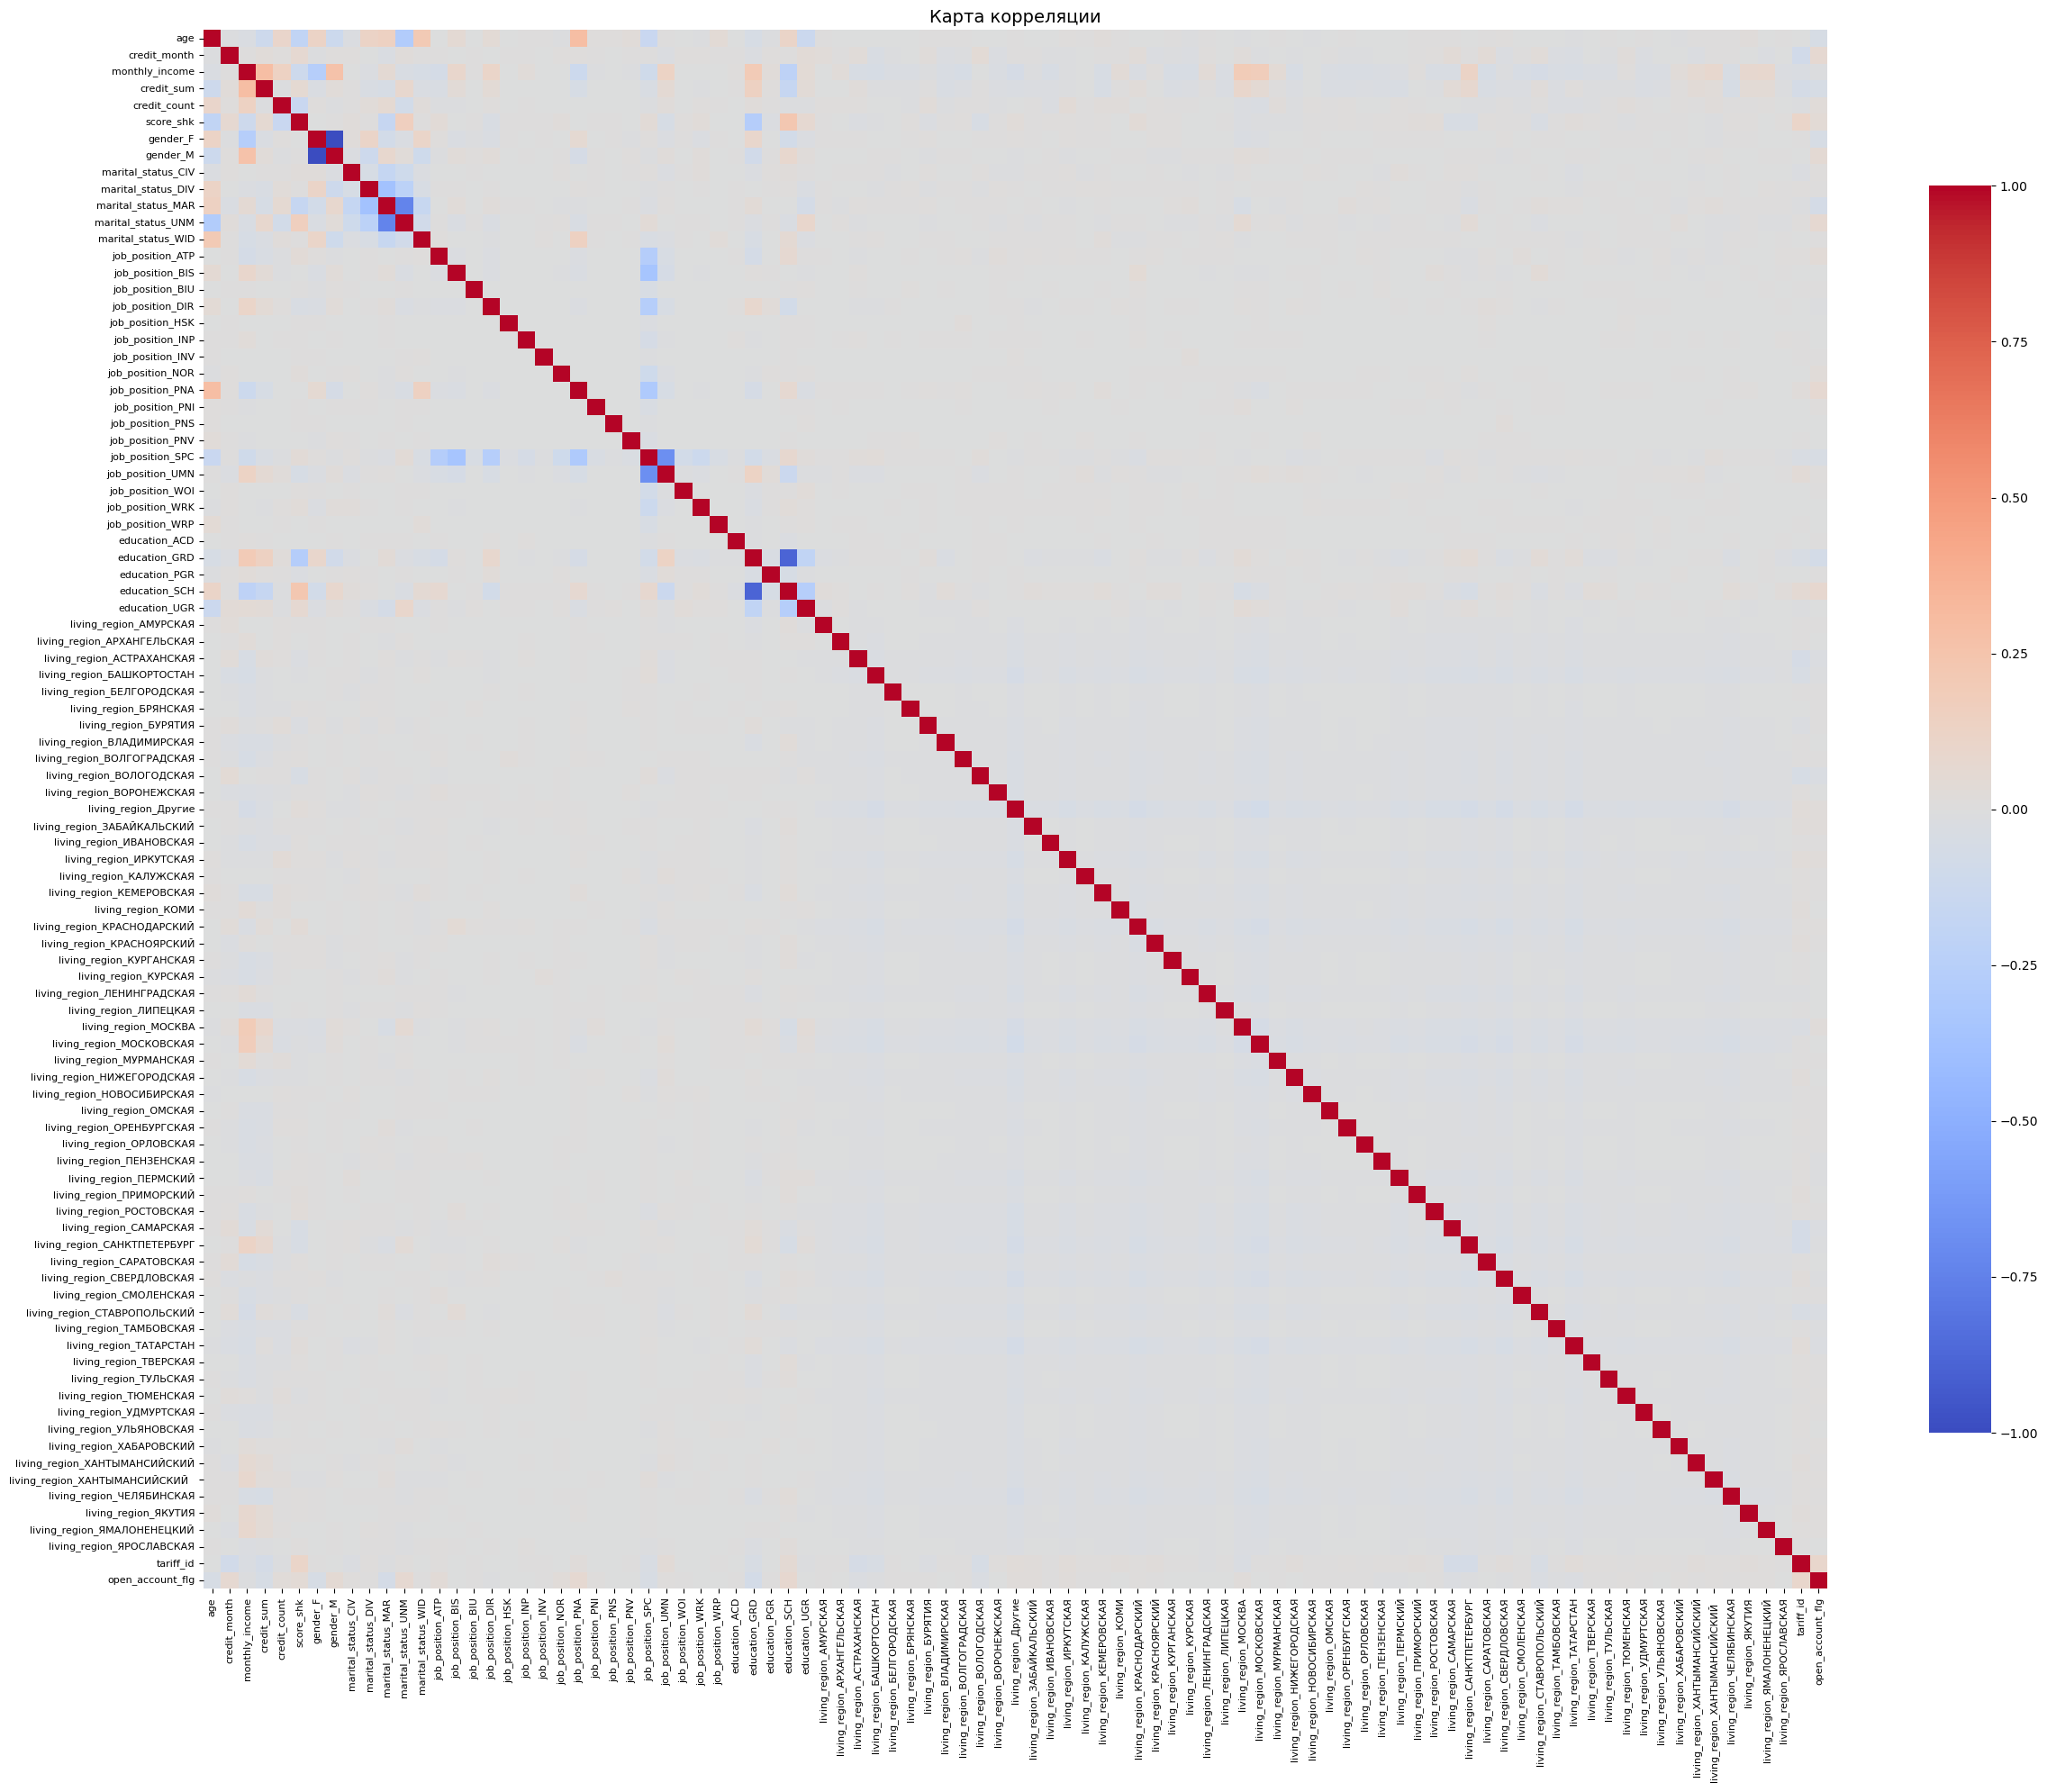

In [283]:
correlation_matrix = result.corr()

# Настраиваем размеры фигуры для лучшей читаемости
plt.figure(figsize=(25, 20))  # Размеры графика

sns.heatmap(
    correlation_matrix,
    annot=False,               # Не отображать числовые значения на ячейках
    cmap="coolwarm",           # Цветовая карта
    vmin=-1, vmax=1,           # Ограничения для значений корреляции
    cbar_kws={"shrink": 0.8}   # Уменьшение размера цветовой полосы
)


# Настраиваем подписи осей
plt.xticks(rotation=90, fontsize=8) 
plt.yticks(fontsize=8)               
plt.title("Карта корреляции", fontsize=14)  # Заголовок

plt.tight_layout()  # Подгонка элементов графика
plt.show()

Видно, что корреляция признаков до и после скалирования отличается незначительно.

Выводы:
    1. Датасет потребовал предварительной обработки: фильтрации признаков living_region, приведения типов. В виду большого количества признаков living_region, признаки, встречающиеся меньше медианного значения раз, сгрупированы вместе.
    2. Изначальное количество пропусков в данных (в основном столбцы credit_count и overdue_credit_count) около 5.5 %. Пропуски в этих столбцах заменены на медианные значения, в виду относительно большого их количества. Остальные пропуски удалены.
    3. В числовых данных присутствуют выбросы. Выбросы удалены методом межквартильного размаха (границы в 25% и 75% значений).
    4. В датасете нет параметров с нормально распределенными значениями (по критерию Пирсона).
    5. БОльшая часть параметров датасета не коррелирует друг с другом, за исключением описанных выше в ходе работы.
